In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preannealing_pt import Ec

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.stats import linregress
import seaborn as sns

palette = 'BuPu' # Theme for plot
dpi = 200 
linewidth = 1
figsize = [20,5]
cols = ['Potential vs Li$^+$/Li (V)', 'Current (A)', 'Current Density ($\mu$A/cm$^2$)', 'Scan']
cols2 = ['Time (s)', cols[0], 'Current (A)', 'Charge (C)', 'Capacity (mAh cm$^{-3}$)']
_cap = 'Capacity (mAh/cm$^3$)'

def ec(path, thickness, area, sample_name):
    delith = pd.DataFrame()
    lith = pd.DataFrame()
    cv_df = pd.DataFrame()
    capacity = pd.DataFrame(columns = [_cap, 'Cycle', 'Sample', 'Average Current Density ($\mu$A/cm$^3$)', 'Charge/Discharge'])
    capacity_d = pd.DataFrame(columns = [_cap, 'Cycle', 'Sample', 'Average Current Density ($\mu$A/cm$^3$)', 'Charge/Discharge'])
    final_file = pd.DataFrame()
    efficiency = pd.DataFrame()
    for i in os.listdir(path):                          # make 3 folders in path: CV, delith, lith to separate files
        if 'CV' not in os.listdir(path):
            os.mkdir(os.path.join(path, 'CV'))
            os.mkdir(os.path.join(path, 'delith'))
            os.mkdir(os.path.join(path, 'lith'))
        if '_CV_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'CV', i))
        elif '_delith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'delith', i))
        elif '_lith_' in i:
            os.rename(os.path.join(path, i), os.path.join(path, 'lith', i))
    f_delith = [os.path.join(path, 'delith', i)  for i in os.listdir(os.path.join(path, 'delith')) if i != 'README.txt']
    f_lith = [os.path.join(path, 'lith', i)  for i in os.listdir(os.path.join(path, 'lith')) if i != 'README.txt']
    m = 1
    for i in f_delith:
        if '_' in  i[-6]:
            os.renames(i, i[:-5] + '0' + str(m) + '.txt')
            m += 1 
    m = 1
    for i in f_lith:
        if '_' in  i[-6]:
            os.renames(i, i[:-5] + '0' + str(m) + '.txt')
            m += 1 
    files = [os.path.join(path, i)  for i in os.listdir(path) if i != 'README.txt']
    # Plot CV, actiation and final together if both are available
    for i in files:                             
        if '\CV' in i[-3:]:
            cv_files = [os.path.join(i, j) for j in os.listdir(i)] 
            cv_files.sort(reverse = True)
            fig, ax = plt.subplots(facecolor = 'white', dpi = dpi)
            for x in cv_files:
                cv = pd.read_csv(x, names = cols, sep = ';', skiprows=1, usecols=[0, 1, 4,5])
                cv[cols[2]] = cv[cols[1]] / area * 1e6 
                if '_Initial_' in x:
                    label = 'Activation CV'
                else:
                    label = 'Final CV'
                cv['CV'] = label
                cv_df = pd.concat([cv_df, cv])
                sns.scatterplot(data = cv, x = cols[0], y = cols[2], edgecolor = None, s = 3, ax = ax)
                            
    # Plot delith profiles
        elif 'delith' in i:
            delith_files = [os.path.join(i, j) for j in os.listdir(i)]
            if len(delith_files) < 1:
                pass
            else:
                Z = [[0,0],[0,0]]                                                                       # Creates color bar
                cbar = plt.contourf(Z, levels = np.arange(0, len(delith_files) + 1, 1), cmap=palette)
                plt.clf()
                n = 0
                for x in delith_files:
                    dl = pd.read_csv(x, sep = ';', names = cols2, usecols=[1,2,3,4,5], skiprows = 1)
                    dl['Cycle'] = int(x[-6:-4])
                    delith = pd.concat([delith, dl], ignore_index=True) # appending to data frame
                    c_d = max(dl[cols2[3]]) /3.6 / (area * 1e-7 * thickness)
                    capacity_d.loc[n] = [c_d, int(x[-6:-4]), sample_name, dl[cols2[2]].mean() * 1e6 / area, ''] # calculated capacity
                    capacity_d['Charge/Discharge'] = 'Charge'
        
                    n += 1
                
                delith[_cap] = delith[cols2[3]] /3.6 / (area * 1e-7 * thickness)

        # Same as above but for lithiation profiles
        elif '\lith' in i:
            lith_files = [os.path.join(i, j) for j in os.listdir(i)]
            if len(lith_files) < 1:
                pass
            else:
                Z = [[0,0],[0,0]]
                cbar = plt.contourf(Z, levels = np.arange(0, len(lith_files) + 1, 1), cmap=palette)
                plt.clf()
                n = 0
                for x in lith_files:
                    l = pd.read_csv(x, sep = ';', names = cols2, usecols=[1,2,3,4,5], skiprows = 1)
                    l['Cycle'] = int(x[-6:-4])
                    lith = pd.concat([lith, l], ignore_index = True)
                    capacity.loc[n] = [-1 * min(l[cols2[3]]) / 3.6 / (area * 1e-7 * thickness), int(x[-6:-4]), sample_name, l[cols2[2]].mean() * 1e6 / area, ''] # capacity equation. capacity = charge / 3.6 / area * thickness (cm)
                    capacity['Charge/Discharge'] = 'Discharge'
                    n += 1
                lith[_cap] = -1 * lith[cols2[3]] /3.6 / (area * 1e-7 * thickness)
                
    efficiency['Efficiency (%)'] = capacity[_cap] / capacity_d[_cap] * 100
    efficiency['Cycle'] = capacity['Cycle']
    efficiency['Sample'] = sample_name
    final_file = pd.concat([capacity_d, capacity], ignore_index=True)     

    return cv_df, final_file, lith, delith, efficiency     # Returns Data frame with lithiation data (capacity, cycle, sample)


Text(0.5, 0.98, 'LMOref not annealed Pt 0I_20')

<Figure size 1280x960 with 0 Axes>

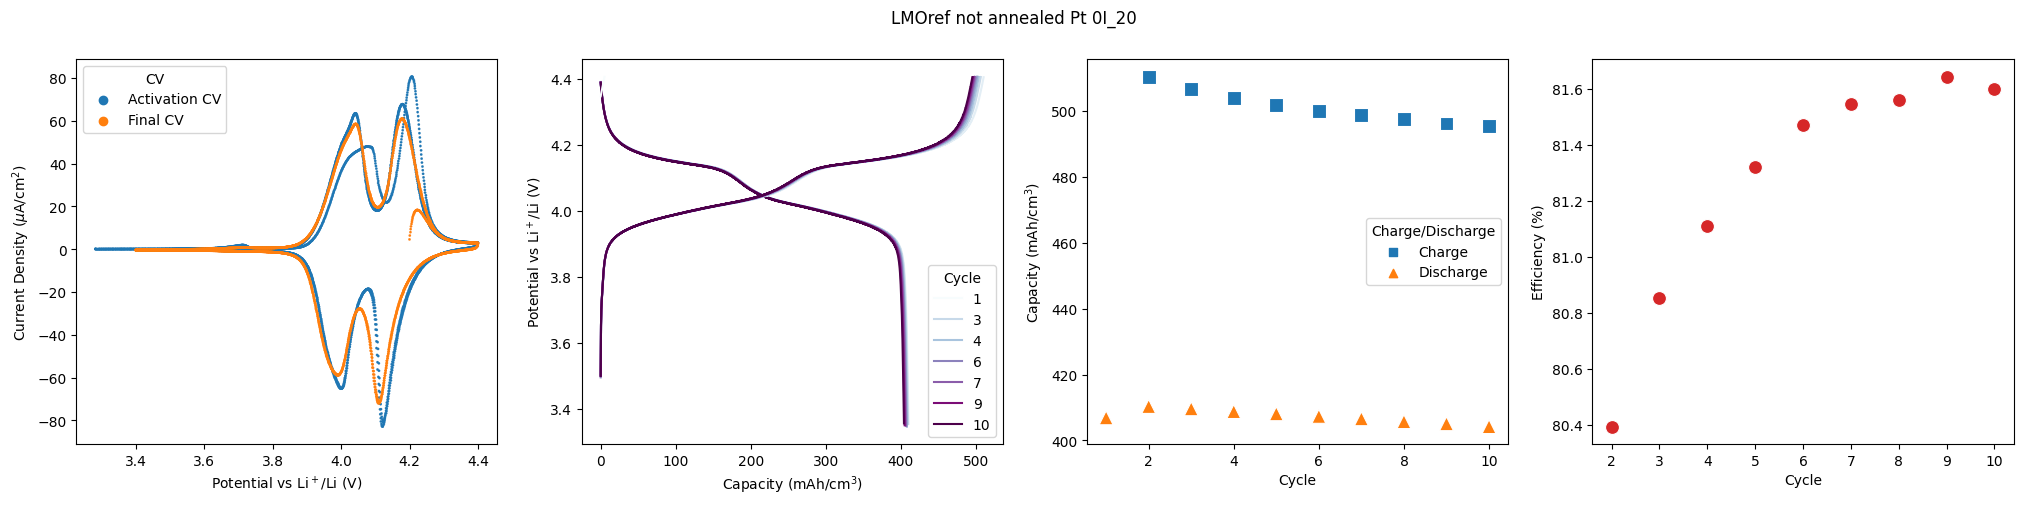

In [18]:
# =============================== LMOref NA Pt ==============================================================================================
path_ref = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\LSB_09\0I_20'
sample = 'LMOref not annealed Pt 0I_20'
df_cv_lmo_ref_na, capacity_lmo_ref_na, lith_lmo_ref_na, delith_lmo_ref_na, efficiency_lmo_ref_na = ec(path_ref, 90, 0.785, sample)
data = [df_cv_lmo_ref_na, capacity_lmo_ref_na, lith_lmo_ref_na, delith_lmo_ref_na]
for i in data:
    i['Sample'] = sample


fig, ax = plt.subplots(1, 4, dpi = 100, figsize = (25, 5))
# ax2 = ax[2].twinx()
sns.scatterplot(data = df_cv_lmo_ref_na, x = 'Potential vs Li$^+$/Li (V)', y = 'Current Density ($\mu$A/cm$^2$)', hue = 'CV', ax = ax[0], edgecolor = None, s = 3)
sns.lineplot(data = lith_lmo_ref_na, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', ax = ax[1], hue = 'Cycle', palette = 'BuPu')
sns.lineplot(data = delith_lmo_ref_na, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', ax = ax[1], hue = 'Cycle', palette = 'BuPu', legend = False)
# ax[1].legend(frameon=False)
sns.scatterplot(data = efficiency_lmo_ref_na[1:], x = 'Cycle' , y = 'Efficiency (%)', ax = ax[3],  c = 'tab:red', s = 100)
sns.scatterplot(data = capacity_lmo_ref_na[1:], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'Charge/Discharge', style = 'Charge/Discharge', ax = ax[2], legend = True, markers = ['s', '^' ], s = 100)
# ax[2].legend(['Efficiency'], loc = 10, frameon = False)
# ax2.legend(frameon = False, loc = 7)
plt.suptitle(sample)

Text(0.5, 0.98, 'Set2 LMO NA')

<Figure size 1280x960 with 0 Axes>

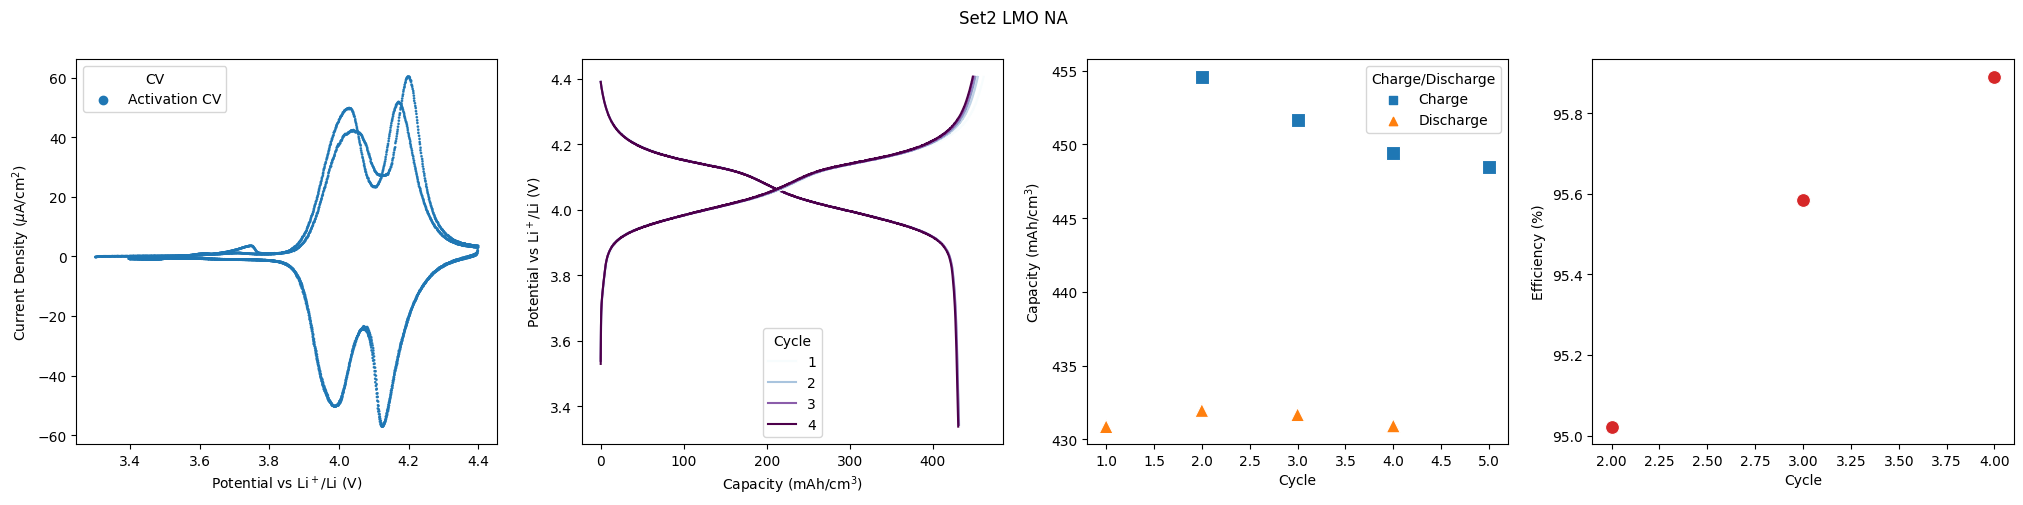

In [19]:
# =============================== LMO NA Pt Set2==============================================================================================
path_ref = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\Preannealing\Set2\NA_01'
sample = 'Set2 LMO NA'
cv_s2_na, capacity_s2_na, lith_s2_na, delith_s2_na, efficiency_s2_na = ec(path_ref, 90, 0.785, sample)
data = [cv_s2_na, capacity_s2_na, lith_s2_na, delith_s2_na]
for i in data:
    i['Sample'] = sample


fig, ax = plt.subplots(1, 4, dpi = 100, figsize = (25, 5))
# ax2 = ax[2].twinx()
sns.scatterplot(data = cv_s2_na, x = 'Potential vs Li$^+$/Li (V)', y = 'Current Density ($\mu$A/cm$^2$)', hue = 'CV', ax = ax[0], edgecolor = None, s = 3)
sns.lineplot(data = lith_s2_na, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', ax = ax[1], hue = 'Cycle', palette = 'BuPu')
sns.lineplot(data = delith_s2_na, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', ax = ax[1], hue = 'Cycle', palette = 'BuPu', legend = False)
# ax[1].legend(frameon=False)
sns.scatterplot(data = efficiency_s2_na[1:], x = 'Cycle' , y = 'Efficiency (%)', ax = ax[3],  c = 'tab:red', s = 100)
sns.scatterplot(data = capacity_s2_na[1:], x = 'Cycle', y = 'Capacity (mAh/cm$^3$)', hue = 'Charge/Discharge', style = 'Charge/Discharge', ax = ax[2], legend = True, markers = ['s', '^' ], s = 100)
# ax[2].legend(['Efficiency'], loc = 10, frameon = False)
# ax2.legend(frameon = False, loc = 7)
plt.suptitle(sample)


(70.0, 100.0)

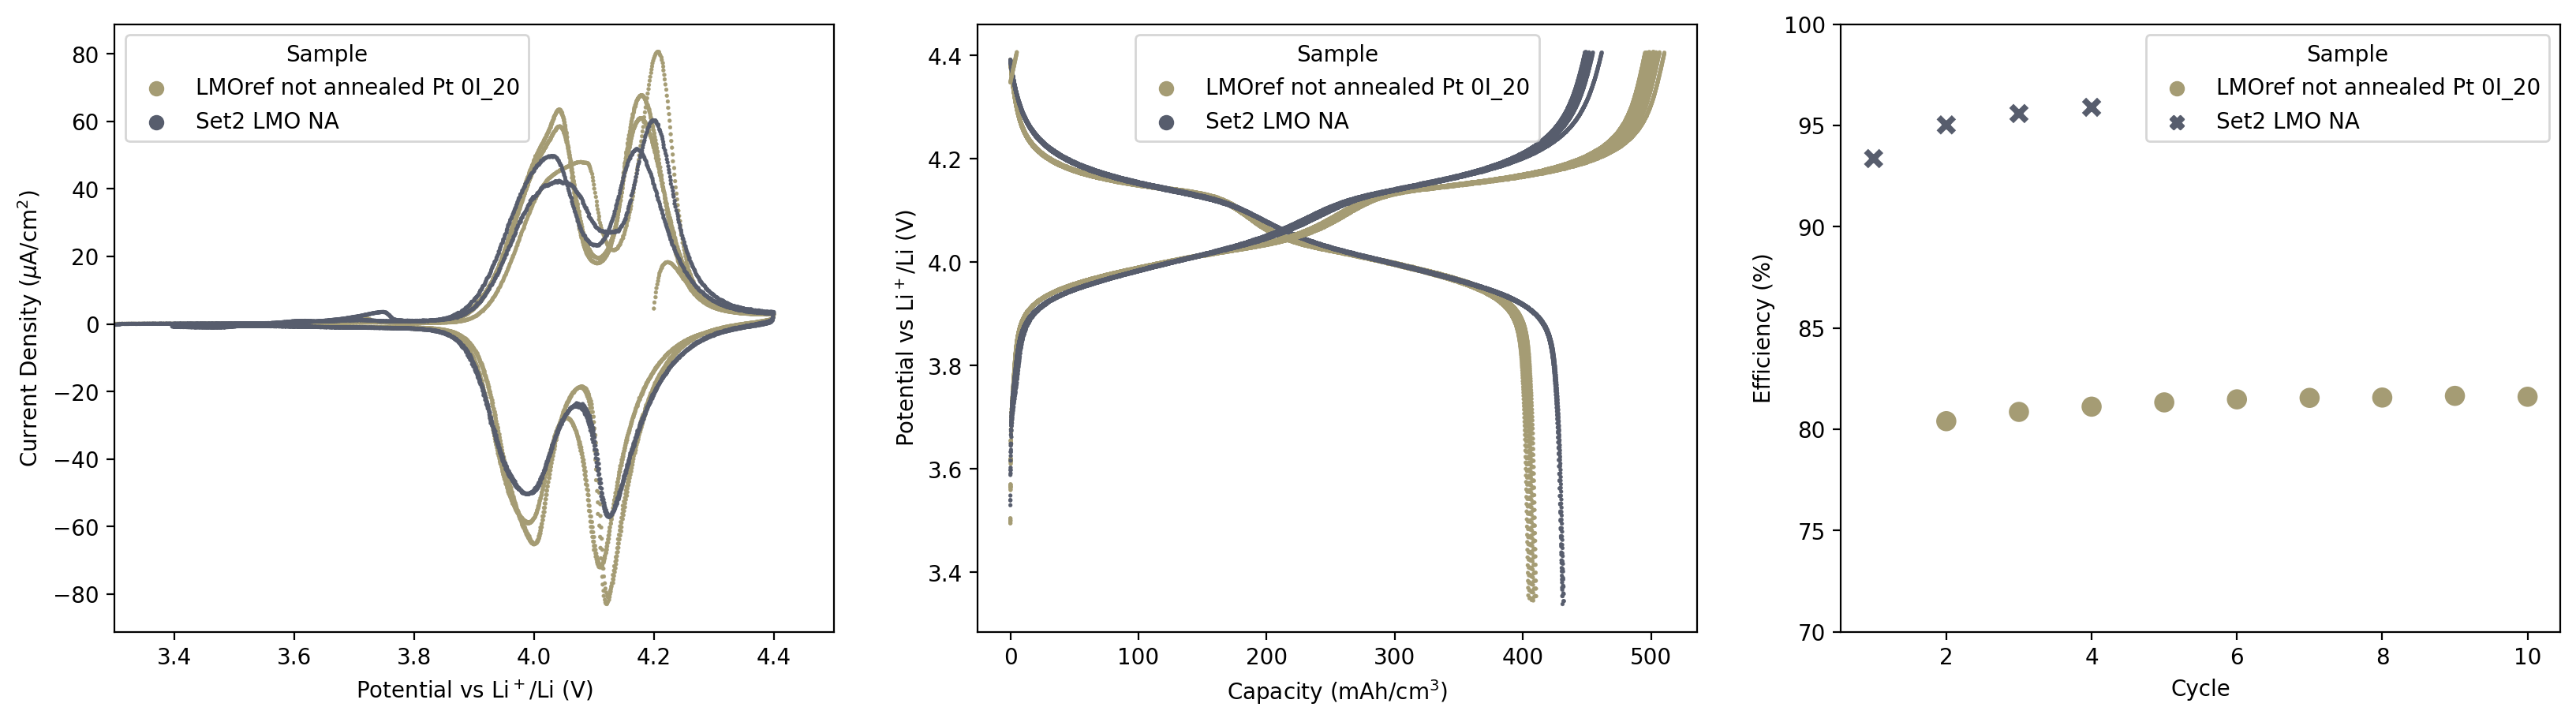

In [20]:
# ======================= COMPARE =======================================
palette = 'cividis_r'

cv = pd.concat([df_cv_lmo_ref_na, cv_s2_na], ignore_index=True) 

lithiation = pd.concat([lith_lmo_ref_na, lith_s2_na], ignore_index=True) # , lith_lmo_ref_na

# capacity_all = pd.concat([], ignore_index=True) 

delithiation = pd.concat([ delith_lmo_ref_na, delith_s2_na], ignore_index=True) #, , delith_lmo_ref_na,

efficiency = pd.concat([ efficiency_lmo_ref_na, efficiency_s2_na], ignore_index= True) # , efficiency_lmo_na, efficiency_lmo_ref_na,

# ========== PLOT CV ================================================================================
fig, ax = plt.subplots(1, 3, figsize = (20,5), dpi = 200)
sns.scatterplot(data = cv, x = 'Potential vs Li$^+$/Li (V)', y = 'Current Density ($\mu$A/cm$^2$)', hue = 'Sample', edgecolor = None, s = 3, ax = ax[0], palette=palette)
# ax.legend(bbox_to_anchor=(1,1), frameon = False)
ax[0].set_xlim(3.3, 4.5)

# ========== PLOT lith ================================================================================

sns.scatterplot(data = lithiation, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', hue = 'Sample',  edgecolor = None, s = 3, ax = ax[1], palette=palette)
sns.scatterplot(data = delithiation, x = 'Capacity (mAh/cm$^3$)', y = 'Potential vs Li$^+$/Li (V)', hue = 'Sample', edgecolor = None, s = 3, ax = ax[1], palette=palette, legend = False)

sns.scatterplot(data = efficiency[1:], x = 'Cycle',  y = 'Efficiency (%)', ax = ax[2], hue = 'Sample', style = 'Sample', palette=palette, s = 100)
ax[2].set_ylim(70,100)
